In [66]:
import os
import rasterio

# Path to the R10m folder
r10m_path = "/Users/lucasertugrul/LauzHack2024-1/S2B_MSIL2A_20191215T033139_N0500_R018_T48PVV_20230608T231247.SAFE/GRANULE/L2A_T48PVV_A014487_20191215T033644/IMG_DATA/R10m"

# Create a dictionary to store loaded bands
r10m_bands = {}

# Loop through all .jp2 files in the R10m folder
for file in os.listdir(r10m_path):
    if file.endswith(".jp2"):
        band_path = os.path.join(r10m_path, file)
        
        # Extract the band name (e.g., B02 for Blue)
        band_name = os.path.splitext(file)[0]
        
        # Load the band with Rasterio
        with rasterio.open(band_path) as src:
            r10m_bands[band_name] = src.read(1)  # Read the band data

# Display loaded bands
print("Loaded Bands:", list(r10m_bands.keys()))


Loaded Bands: ['T48PVV_20191215T033139_B08_10m', 'T48PVV_20191215T033139_B03_10m', 'T48PVV_20191215T033139_B02_10m', 'T48PVV_20191215T033139_TCI_10m', 'T48PVV_20191215T033139_WVP_10m', 'T48PVV_20191215T033139_B04_10m', 'T48PVV_20191215T033139_AOT_10m']


In [67]:
# Access Band 4 (Red)
red_band = r10m_bands["T48PVV_20191215T033139_B04_10m"]

# Access Band 8 (NIR)
nir_band = r10m_bands["T48PVV_20191215T033139_B08_10m"]


In [68]:
# Save the Red band as a GeoTIFF
output_path = "red_band.tif"
with rasterio.open(band_path) as src:
    meta = src.meta
    meta.update({"driver": "GTiff", "dtype": "float32"})  # Update metadata

    with rasterio.open(output_path, "w", **meta) as dst:
        dst.write(red_band, 1)  # Write band 1


In [69]:
import matplotlib.pyplot as plt

# Display the Red band
plt.imshow(red_band[0:1000], cmap="gray")
plt.title("Red Band (B04)")
plt.colorbar(label="Reflectance")
plt.show()

# Display the NIR band
plt.imshow(nir_band, cmap="gray")
plt.title("NIR Band (B08)")
plt.colorbar(label="Reflectance")
plt.show()


In [70]:
# Save the Red band as a GeoTIFF
output_path = "red_band.tif"
with rasterio.open(band_path) as src:
    meta = src.meta
    meta.update({"driver": "GTiff", "dtype": "float32"})  # Update metadata

    with rasterio.open(output_path, "w", **meta) as dst:
        dst.write(red_band, 1)  # Write band 1


In [71]:
%pip install rasterio ipyleaflet ipywidgets shapely geopandas


Note: you may need to restart the kernel to use updated packages.


In [72]:
from ipyleaflet import Map, DrawControl, basemaps
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import shape, Polygon
from rasterio.mask import mask

# File path to the Red band (Band 4, R10m resolution)
red_band_path = "S2B_MSIL2A_20191215T033139_N0500_R018_T48PVV_20230608T231247.SAFE/GRANULE/L2A_T48PVV_A014487_20191215T033644/IMG_DATA/R10m/T48PVV_20191215T033139_B04_10m.jp2"

# Step 1: Load the Red Band using Rasterio
with rasterio.open(red_band_path) as src:
    red_band = src.read(1)  # Read the first band
    red_meta = src.meta  # Metadata of the raster
    red_transform = src.transform  # Transformation matrix
    red_bounds = src.bounds  # Bounds of the raster

# Display the Red band (full extent)
plt.figure(figsize=(10, 8))
plt.imshow(red_band, cmap="Reds")
plt.title("Red Band (Full Extent)")
plt.colorbar(label="Reflectance")
plt.show()

# Step 2: Initialize an Interactive Map
# Center the map on the bounds of the raster
map_center = ((red_bounds.top + red_bounds.bottom) / 2, (red_bounds.left + red_bounds.right) / 2)

# Initialize the map with the correct basemap
m = Map(center=(map_center[1], map_center[0]), zoom=12, basemap=basemaps.CartoDB.Positron)

# Add drawing controls to the map
draw_control = DrawControl()
draw_control.polygon = {"shapeOptions": {"color": "#0000FF", "weight": 2, "fillOpacity": 0.1}}
draw_control.rectangle = {"shapeOptions": {"color": "#FF0000", "weight": 2, "fillOpacity": 0.1}}
m.add_control(draw_control)

# Step 3: Capture AOI Coordinates
aoi_coordinates = []  # Global variable to store AOI coordinates

def handle_draw(self, action, geo_json):
    """
    Callback function to capture the geometry drawn on the map.
    """
    global aoi_coordinates
    print(f"Geometry drawn: {geo_json['geometry']['type']}")
    print(f"Coordinates: {geo_json['geometry']['coordinates']}")
    aoi_coordinates = geo_json['geometry']['coordinates']  # Store coordinates

# Attach the callback to the DrawControl
draw_control.on_draw(handle_draw)

# Display the map
m


Map(center=[454860.0, 1445100.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', …

In [73]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.windows import Window

# File path to the Red band (Band 4, R10m resolution)
red_band_path = "S2B_MSIL2A_20191215T033139_N0500_R018_T48PVV_20230608T231247.SAFE/GRANULE/L2A_T48PVV_A014487_20191215T033644/IMG_DATA/R10m/T48PVV_20191215T033139_B04_10m.jp2"
blue_band_path = "S2B_MSIL2A_20191215T033139_N0500_R018_T48PVV_20230608T231247.SAFE/GRANULE/L2A_T48PVV_A014487_20191215T033644/IMG_DATA/R10m/T48PVV_20191215T033139_B02_10m.jp2"


# Step 1: Load the Red Band using Rasterio
with rasterio.open(red_band_path) as src:
    red_band = src.read(1)  # Read the full band
    red_transform = src.transform  # Transformation matrix
    width, height = src.width, src.height  # Raster dimensions
    red_bounds = src.bounds  # Bounds of the raster
    
    # Load the Blue Band
with rasterio.open(blue_band_path) as src:
    blue_band = src.read(1)  # Read the full band
    blue_transform = src.transform  # Transformation matrix
    width, height = src.width, src.height  # Raster dimensions
    blue_bounds = src.bounds  # Bounds of the raster


# Step 2: Calculate the Center of the Raster
center_x = width // 2
center_y = height // 2
print(f"Raster center (pixel coordinates): ({center_x}, {center_y})")

# Step 3: Define a Window for Zooming
window_size = 1000  # Define the size of the zoomed area (in pixels)
window = Window(center_x - window_size // 2, center_y - window_size // 2, window_size, window_size)

# Step 4: Crop the Raster Data Using the Window
with rasterio.open(red_band_path) as src:
    zoomed_in_band_red = src.read(1, window=window)  # Read the windowed data
    zoomed_transform = src.window_transform(window)  # Get the transform for the zoomed area
    
with rasterio.open(blue_band_path) as src:
    zoomed_in_band_blue = src.read(1, window=window)  # Read the windowed data
    zoomed_transform = src.window_transform(window)  # Get the transform for the zoomed area

# Display the zoomed-in area
plt.figure(figsize=(8, 8))
plt.imshow(zoomed_in_band_red, cmap="Reds")

plt.title(f"Zoomed-In Red Band (Center {window_size}x{window_size})")
plt.colorbar(label="Reflectance")
plt.show()
plt.imshow(zoomed_in_band_blue, cmap="Blues")

Raster center (pixel coordinates): (5490, 5490)


In [74]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from rasterio.features import geometry_mask

# Step 1: Define the Polygon Mask
# Define a polygon in pixel coordinates
polygon_coords = [
    (450, 750),  # Top-left
    (660, 750),  # Top-right
    (630, 900),  # Bottom-right
    (420, 850),  # Bottom-left
    (450, 750)   # Close the polygon
    
]
polygon = Polygon(polygon_coords)

# Step 2: Create a Mask from the Polygon
# The shape of the zoomed_in_band is used as the output shape
mask = geometry_mask(
    [polygon],  # List of geometries
    transform=rasterio.transform.Affine.translation(0, 0),  # Identity transform (pixel coordinates)
    invert=True,  # Invert the mask so the polygon area is True
    out_shape=zoomed_in_band.shape
)

# Step 3: Apply the Mask
# Set pixels outside the polygon to 0 or apply opacity
opacity = 0.2
masked_band_red = np.copy(zoomed_in_band_red)
masked_band_red[~mask] = opacity * masked_band_red[~mask]  # Apply opacity outside the polygon
masked_band_blue = np.copy(zoomed_in_band_blue)
masked_band_blue[~mask] = opacity * masked_band_blue[~mask]  # Apply opacity outside

# Step 4: Visualize the Result
plt.figure(figsize=(8, 8))
plt.imshow(masked_band_red, cmap="Reds")

plt.title("Masked Red Band (Polygon Mask)")
plt.colorbar(label="Reflectance")
plt.show()
plt.imshow(masked_band_blue, cmap="Blues")


In [75]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from rasterio.features import geometry_mask

# File paths to the bands
band_files = {
    "AOT": "S2B_MSIL2A_20191215T033139_N0500_R018_T48PVV_20230608T231247.SAFE/GRANULE/L2A_T48PVV_A014487_20191215T033644/IMG_DATA/R10m/T48PVV_20191215T033139_AOT_10m.jp2",
    "B02": "S2B_MSIL2A_20191215T033139_N0500_R018_T48PVV_20230608T231247.SAFE/GRANULE/L2A_T48PVV_A014487_20191215T033644/IMG_DATA/R10m/T48PVV_20191215T033139_B02_10m.jp2",
    "B03": "S2B_MSIL2A_20191215T033139_N0500_R018_T48PVV_20230608T231247.SAFE/GRANULE/L2A_T48PVV_A014487_20191215T033644/IMG_DATA/R10m/T48PVV_20191215T033139_B03_10m.jp2",
    "B04": "S2B_MSIL2A_20191215T033139_N0500_R018_T48PVV_20230608T231247.SAFE/GRANULE/L2A_T48PVV_A014487_20191215T033644/IMG_DATA/R10m/T48PVV_20191215T033139_B04_10m.jp2",
    "B08": "S2B_MSIL2A_20191215T033139_N0500_R018_T48PVV_20230608T231247.SAFE/GRANULE/L2A_T48PVV_A014487_20191215T033644/IMG_DATA/R10m/T48PVV_20191215T033139_B08_10m.jp2",
    "TCI": "S2B_MSIL2A_20191215T033139_N0500_R018_T48PVV_20230608T231247.SAFE/GRANULE/L2A_T48PVV_A014487_20191215T033644/IMG_DATA/R10m/T48PVV_20191215T033139_TCI_10m.jp2",
    "WVP": "S2B_MSIL2A_20191215T033139_N0500_R018_T48PVV_20230608T231247.SAFE/GRANULE/L2A_T48PVV_A014487_20191215T033644/IMG_DATA/R10m/T48PVV_20191215T033139_WVP_10m.jp2"
}

# Step 1: Define the Polygon Mask
polygon_coords = [
    (450, 750),  # Top-left
    (660, 750),  # Top-right
    (630, 900),  # Bottom-right
    (420, 850),  # Bottom-left
    (450, 750)   # Close the polygon
]
polygon = Polygon(polygon_coords)

# Step 2: Initialize storage for masked bands
masked_bands = {}

# Step 3: Iterate over each band, apply the mask, and store the results
for band_name, band_path in band_files.items():
    with rasterio.open(band_path) as src:
        # Zoom into the dataset (center with a predefined window)
        center_x, center_y = src.width // 2, src.height // 2
        window_size = 1000
        window = rasterio.windows.Window(
            center_x - window_size // 2,
            center_y - window_size // 2,
            window_size,
            window_size
        )
        band_data = src.read(1, window=window)
        zoomed_transform = src.window_transform(window)
        
        # Create the mask
        mask = geometry_mask(
            [polygon],
            transform=zoomed_transform,
            invert=True,
            out_shape=band_data.shape
        )
        
        # Apply the mask
        opacity = 0.1
        masked_band = np.copy(band_data)
        masked_band[~mask] = opacity * masked_band[~mask]
        
        # Store the masked band
        masked_bands[band_name] = masked_band

# Step 4: Visualize an example (e.g., B04)
plt.figure(figsize=(8, 8))
plt.imshow(masked_bands["B04"], cmap="Reds")
plt.title("Masked B04 Band (Polygon Mask)")
plt.colorbar(label="Reflectance")
plt.show()

# Step 5: Compute Useful Metrics
# NDVI (Normalized Difference Vegetation Index) = (NIR - Red) / (NIR + Red)
if "B08" in masked_bands and "B04" in masked_bands:
    ndvi = (masked_bands["B08"] - masked_bands["B04"]) / (masked_bands["B08"] + masked_bands["B04"])
    plt.figure(figsize=(8, 8))
    plt.imshow(ndvi, cmap="RdYlGn")
    plt.title("NDVI (Normalized Difference Vegetation Index)")
    plt.colorbar(label="NDVI")
    plt.show()

# NDMI (Normalized Difference Moisture Index) = (NIR - SWIR) / (NIR + SWIR)
if "B08" in masked_bands and "WVP" in masked_bands:
    ndmi = (masked_bands["B08"] - masked_bands["WVP"]) / (masked_bands["B08"] + masked_bands["WVP"])
    plt.figure(figsize=(8, 8))
    plt.imshow(ndmi, cmap="BrBG")
    plt.title("NDMI (Normalized Difference Moisture Index)")
    plt.colorbar(label="NDMI")
    plt.show()

# Step 6: Compute Field Area (in pixels and real-world units)
# Pixels inside the polygon
field_pixels = np.sum(mask)
pixel_area = 10 * 10  # Sentinel-2 resolution for 10m bands (m² per pixel)
field_area_m2 = field_pixels * pixel_area
field_area_ha = field_area_m2 / 10_000  # Convert to hectares
print(f"Field Area: {field_area_m2:.2f} m² ({field_area_ha:.2f} ha)")

# Save NDVI and NDMI as outputs
ndvi_output_path = "ndvi_masked_field.tif"
ndmi_output_path = "ndmi_masked_field.tif"

# Update metadata for saving
with rasterio.open(band_files["B08"]) as src:
    output_meta = src.meta.copy()
    output_meta.update({
        "height": ndvi.shape[0],
        "width": ndvi.shape[1],
        "transform": zoomed_transform,
        "driver": "GTiff"
    })

# Save NDVI
with rasterio.open(ndvi_output_path, "w", **output_meta) as dest:
    dest.write(ndvi, 1)
print(f"NDVI saved to {ndvi_output_path}")

# Save NDMI
with rasterio.open(ndmi_output_path, "w", **output_meta) as dest:
    dest.write(ndmi, 1)
print(f"NDMI saved to {ndmi_output_path}")


Field Area: 0.00 m² (0.00 ha)
NDVI saved to ndvi_masked_field.tif
NDMI saved to ndmi_masked_field.tif


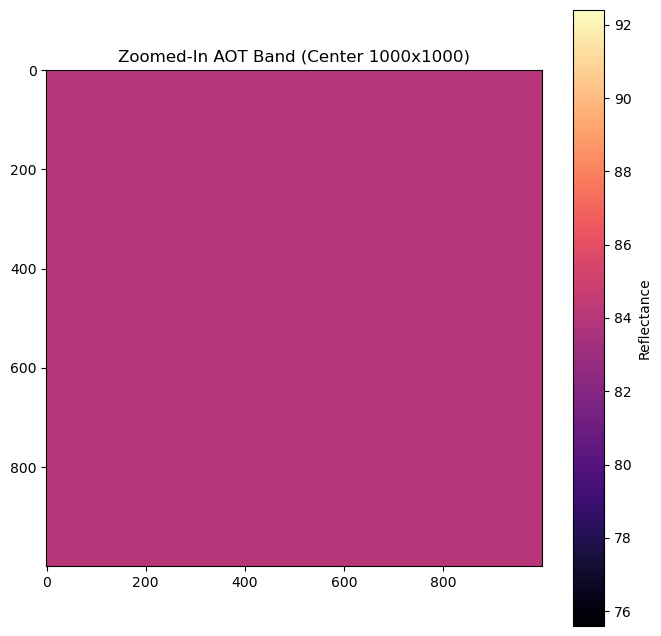

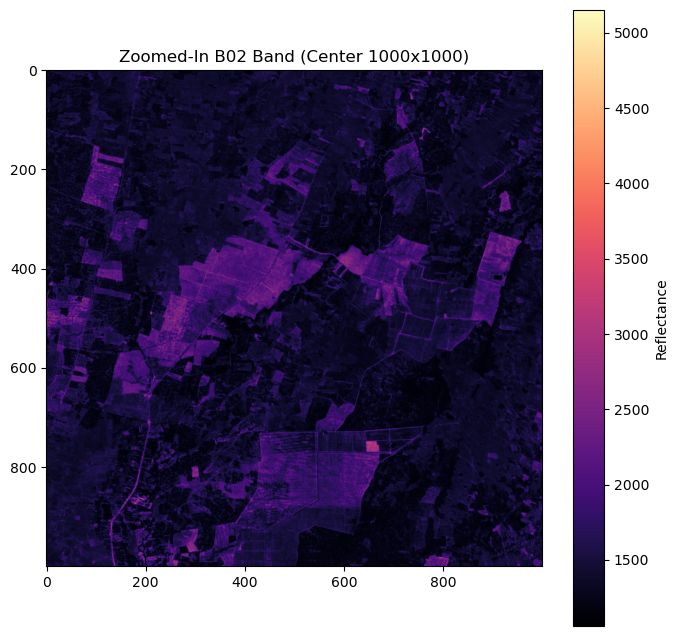

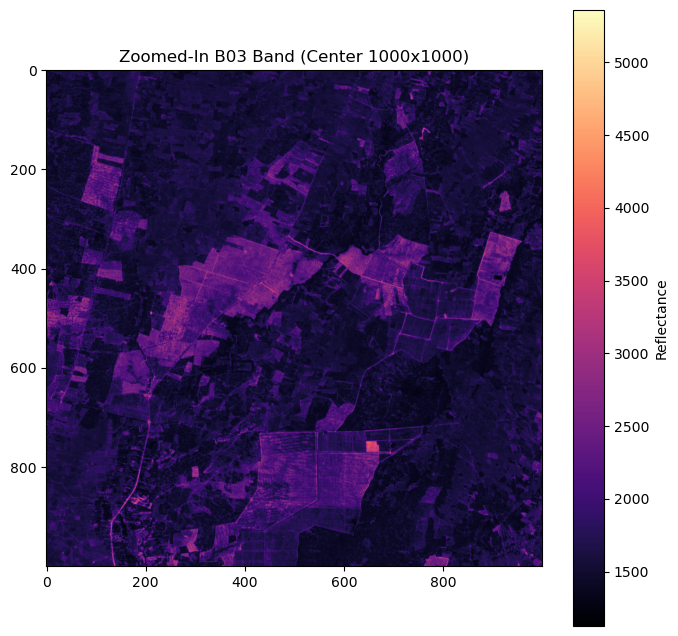

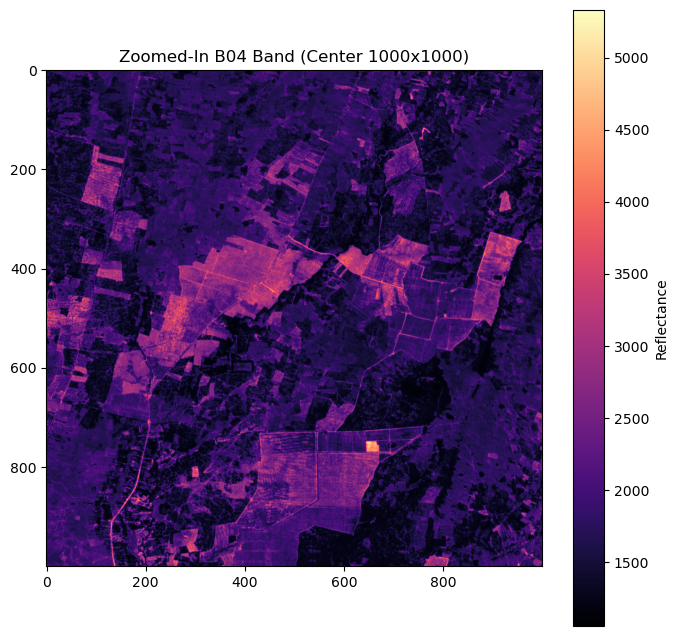

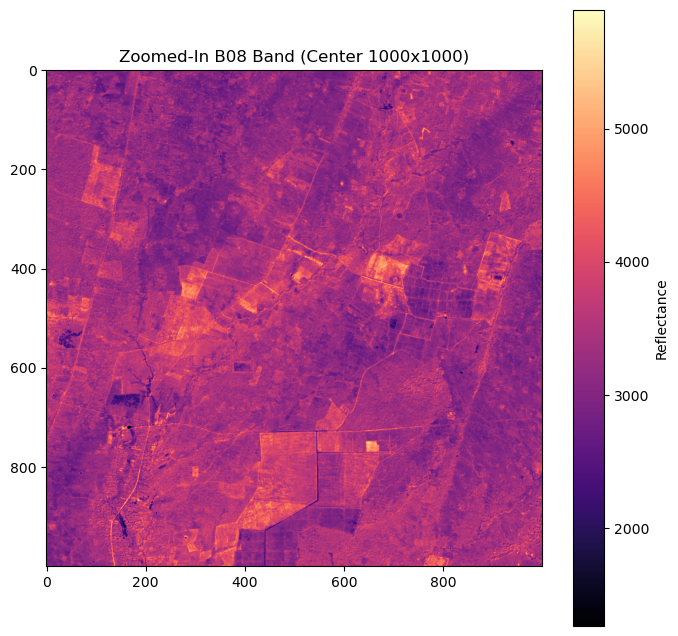

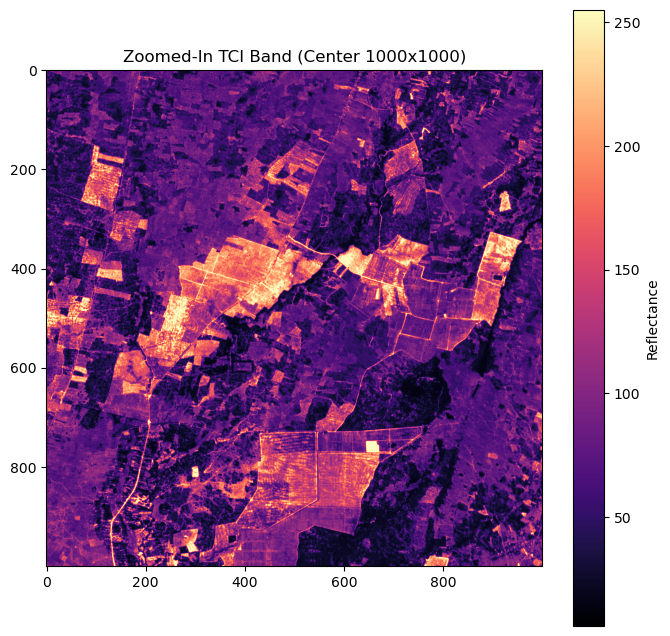

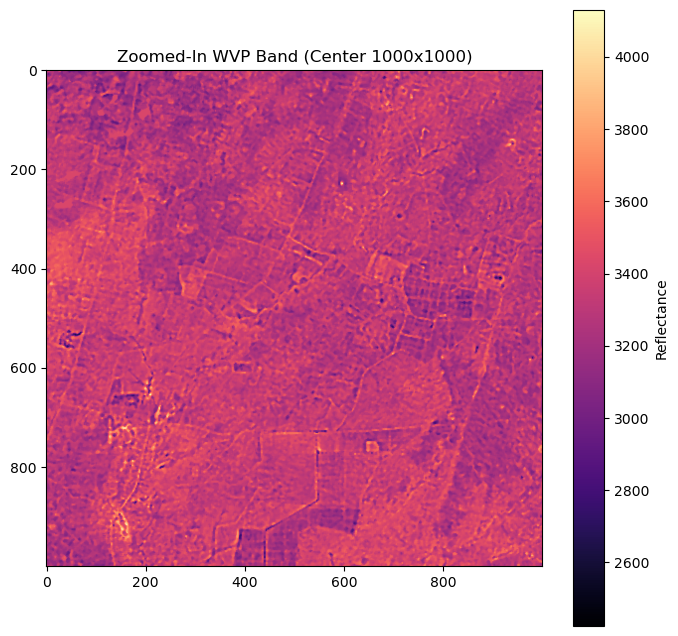

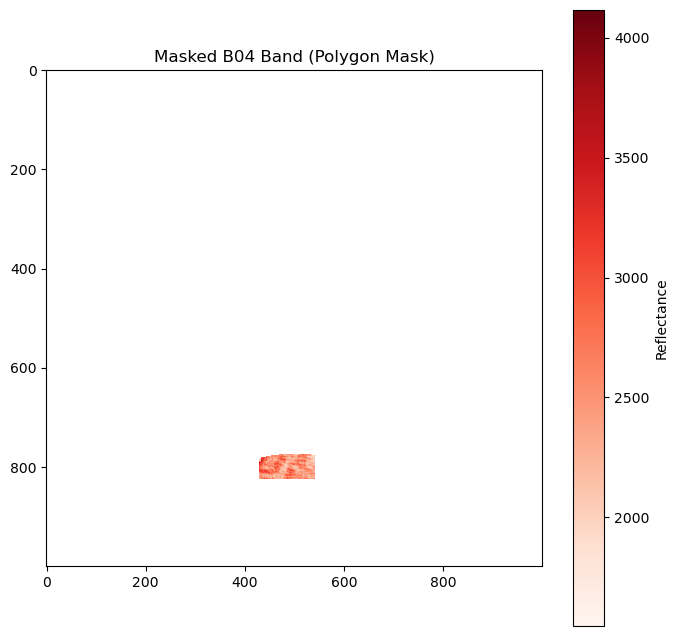

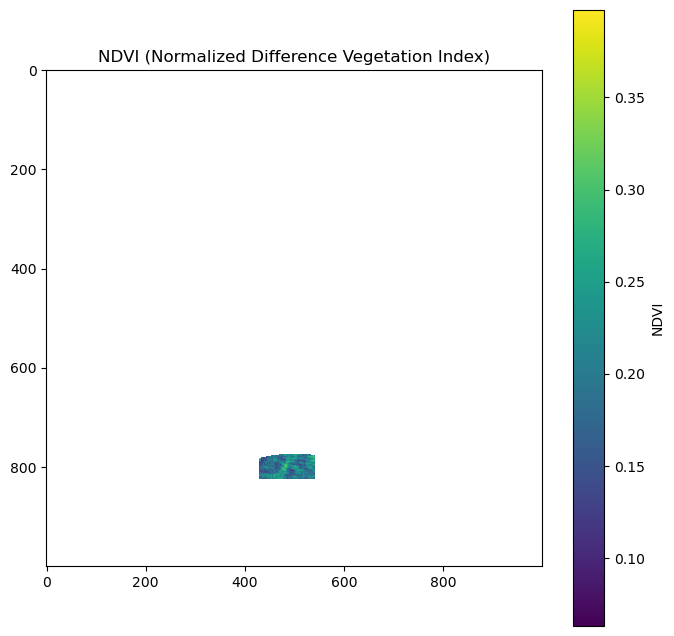

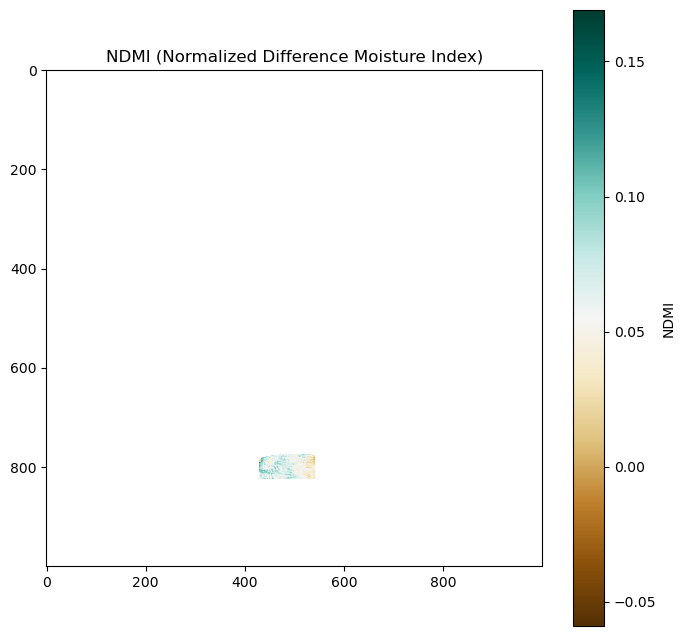

Metrics for the masked area:
{
    "field_area": {
        "pixels": 6018,
        "square_meters": 601800,
        "hectares": 60.18
    },
    "ndvi": {
        "mean": 0.20378953218460083,
        "min": 0.06327801197767258,
        "max": 0.3974200487136841,
        "std": 0.04110993444919586
    },
    "ndmi": {
        "mean": 0.06140042841434479,
        "min": -0.058899886906147,
        "max": 0.16905713081359863,
        "std": 0.022502660751342773
    },
    "savi": {
        "mean": 0.30565953254699707,
        "min": 0.09491086006164551,
        "max": 0.5960774421691895,
        "std": 0.06165852025151253
    },
    "evi": {
        "mean": 0.6638631224632263,
        "min": 0.13147082924842834,
        "max": 1.8786982297897339,
        "std": 0.17400819063186646
    }
}
NDVI saved to ndvi_masked_field.tif
NDMI saved to ndmi_masked_field.tif


In [20]:
import rasterio
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from rasterio.features import geometry_mask
import json

# File paths to the bands (ensure these paths are correct on your system)
band_files = {
    "AOT": "S2B_MSIL2A_20191215T033139_N0500_R018_T48PVV_20230608T231247.SAFE/GRANULE/L2A_T48PVV_A014487_20191215T033644/IMG_DATA/R10m/T48PVV_20191215T033139_AOT_10m.jp2",
    "B02": "S2B_MSIL2A_20191215T033139_N0500_R018_T48PVV_20230608T231247.SAFE/GRANULE/L2A_T48PVV_A014487_20191215T033644/IMG_DATA/R10m/T48PVV_20191215T033139_B02_10m.jp2",
    "B03": "S2B_MSIL2A_20191215T033139_N0500_R018_T48PVV_20230608T231247.SAFE/GRANULE/L2A_T48PVV_A014487_20191215T033644/IMG_DATA/R10m/T48PVV_20191215T033139_B03_10m.jp2",
    "B04": "S2B_MSIL2A_20191215T033139_N0500_R018_T48PVV_20230608T231247.SAFE/GRANULE/L2A_T48PVV_A014487_20191215T033644/IMG_DATA/R10m/T48PVV_20191215T033139_B04_10m.jp2",
    "B08": "S2B_MSIL2A_20191215T033139_N0500_R018_T48PVV_20230608T231247.SAFE/GRANULE/L2A_T48PVV_A014487_20191215T033644/IMG_DATA/R10m/T48PVV_20191215T033139_B08_10m.jp2",
    "TCI": "S2B_MSIL2A_20191215T033139_N0500_R018_T48PVV_20230608T231247.SAFE/GRANULE/L2A_T48PVV_A014487_20191215T033644/IMG_DATA/R10m/T48PVV_20191215T033139_TCI_10m.jp2",
    "WVP": "S2B_MSIL2A_20191215T033139_N0500_R018_T48PVV_20230608T231247.SAFE/GRANULE/L2A_T48PVV_A014487_20191215T033644/IMG_DATA/R10m/T48PVV_20191215T033139_WVP_10m.jp2"
}

# Step 1: Initialize storage for masked bands
masked_bands = {}
mask = None  # To store the mask for later use

# We'll create the mask inside the loop after obtaining the zoomed_transform

for band_name, band_path in band_files.items():
    with rasterio.open(band_path) as src:
        # Zoom into the dataset (center with a predefined window)
        center_x, center_y = src.width // 2, src.height // 2
        window_size = 1000 # customizable window size
        window = rasterio.windows.Window(
            center_x - window_size // 2,
            center_y - window_size // 2,
            window_size,
            window_size
        )
        band_data = src.read(1, window=window)
        zoomed_transform = src.window_transform(window)
        # plot the original band
        plt.figure(figsize=(8, 8))
        plt.imshow(band_data, cmap='magma')
        plt.title(f"Zoomed-In {band_name} Band (Center {window_size}x{window_size})")
        plt.colorbar(label="Reflectance")
        plt.show()

        # Create the mask (only once)
        if mask is None:
            # # Define the polygon in pixel coordinates relative to the window
            # # polygon_coords = [
            # #     (450, 750),  # Top-left
            # #     (660, 750),  # Top-right
            # #     (630, 900),  # Bottom-right
            # #     (420, 850),  # Bottom-left
            # #     (450, 750)   # Close the polygon
            # #     ]
            
            # polygon_coords = [
            #     (484.8896103896105, 775.474025974026),
            #     (493.00649350649354, 859.8896103896104),
            #     (629.3701298701301, 868.0064935064935),
            #     (645.6038961038962, 775.474025974026),
            #     (572.5519480519481, 772.2272727272727),
            #     (561.1883116883118, 872.8766233766235),
            #     (484.8896103896105, 775.474025974026),]
        
            # plt.figure(figsize=(8, 8))
            # plt.imshow(band_data, cmap='gray')
            # plt.title('Click to define the polygon vertices, then press Enter')

            # # Let the user click on the image to define the polygon
            # # For an arbitrary number of points, set n=0
            # polygon_coords = plt.ginput(n=0, timeout=0) #repeat the first coordinate so that the polygon closes out
            
            # #make the polygon coords the entire domain 
            # polygon_coords = [
            #     (0, 1000),  # Top-left
            #     (1000, 1000),  # Top-right
            #     (1000, 0),  # Bottom-right
            #     (0, 0),  # Bottom-left
            #     (0, 1000)   # Close the polygon
            #     ]
            polygon_coords = [
            # # polygon_coords = [
(428.0714285714286, 780.3441558441558),
(426.44805194805207, 827.422077922078),
(470.2792207792209, 825.7987012987013),
(501.1233766233767, 825.7987012987013),
(543.331168831169, 825.7987012987013),
(543.331168831169, 809.5649350649351),
(543.331168831169, 790.0844155844156),
(543.331168831169, 773.8506493506493),
(499.50000000000006, 772.2272727272727),
(458.91558441558453, 773.8506493506493),
(428.0714285714286, 780.3441558441558)
            ]
            
            
            plt.close()


            # Convert pixel coordinates to map coordinates using the transform
            polygon_coords_map = [zoomed_transform * (x, y) for x, y in polygon_coords]
            polygon = Polygon(polygon_coords_map)

            # Create the mask
            mask = geometry_mask(
                [polygon],
                transform=zoomed_transform,
                invert=True,
                out_shape=band_data.shape
            )

        # Apply the mask
        masked_band = np.where(mask, band_data, np.nan)

        # Store the masked band
        masked_bands[band_name] = masked_band

# Visualization (optional)
plt.figure(figsize=(8, 8))
plt.imshow(masked_bands["B04"], cmap="Reds")
plt.title("Masked B04 Band (Polygon Mask)")
plt.colorbar(label="Reflectance")
plt.show()


# Step 2: Compute Useful Metrics
# Convert data types to float32 to avoid issues during calculations
if "B08" in masked_bands and "B04" in masked_bands:
    nir = masked_bands["B08"].astype('float32')
    red = masked_bands["B04"].astype('float32')
    ndvi = (nir - red) / (nir + red)
    ndvi_mask = np.where(mask, ndvi, np.nan)  # Apply mask to NDVI

    # Calculate NDVI statistics
    ndvi_mean = np.nanmean(ndvi_mask)
    ndvi_min = np.nanmin(ndvi_mask)
    ndvi_max = np.nanmax(ndvi_mask)
    ndvi_std = np.nanstd(ndvi_mask)

    # Visualize NDVI
    plt.figure(figsize=(8, 8))
    plt.imshow(ndvi_mask, cmap="RdYlGn")
    plt.imshow(ndvi)
    plt.title("NDVI (Normalized Difference Vegetation Index)")
    plt.colorbar(label="NDVI")
    plt.show()
else:
    ndvi = None

# NDMI (Normalized Difference Moisture Index) = (NIR - SWIR) / (NIR + SWIR)
# Since we don't have a SWIR band at 10m resolution, we'll use the Water Vapor Product (WVP) as a proxy
if "B08" in masked_bands and "WVP" in masked_bands:
    nir = masked_bands["B08"].astype('float32')
    swir = masked_bands["WVP"].astype('float32')
    ndmi = (nir - swir) / (nir + swir)
    ndmi_mask = np.where(mask, ndmi, np.nan)  # Apply mask to NDMI

    # Calculate NDMI statistics
    ndmi_mean = np.nanmean(ndmi_mask)
    ndmi_min = np.nanmin(ndmi_mask)
    ndmi_max = np.nanmax(ndmi_mask)
    ndmi_std = np.nanstd(ndmi_mask)
    
    # Visualize NDMI
    plt.figure(figsize=(8, 8))
    plt.imshow(ndmi_mask, cmap="BrBG")
    plt.title("NDMI (Normalized Difference Moisture Index)")
    plt.colorbar(label="NDMI")
    plt.show()
else:
    ndmi = None

# Additional Indices
# SAVI (Soil Adjusted Vegetation Index)
if "B08" in masked_bands and "B04" in masked_bands:
    L = 0.5  # Soil brightness correction factor
    savi = ((nir - red) / (nir + red + L)) * (1 + L)
    savi = np.where(mask, savi, np.nan)
    savi_mean = np.nanmean(savi)
    savi_min = np.nanmin(savi)
    savi_max = np.nanmax(savi)
    savi_std = np.nanstd(savi)
else:
    savi = None

# EVI (Enhanced Vegetation Index)
if "B08" in masked_bands and "B04" in masked_bands and "B02" in masked_bands:
    blue = masked_bands["B02"].astype('float32')
    evi = 2.5 * (nir - red) / (nir + 6 * red - 7.5 * blue + 1)
    evi = np.where(mask, evi, np.nan)
    evi_mean = np.nanmean(evi)
    evi_min = np.nanmin(evi)
    evi_max = np.nanmax(evi)
    evi_std = np.nanstd(evi)
else:
    evi = None

# Step 3: Compute Field Area (in pixels and real-world units)
# Since the mask is now correctly applied, field_pixels should be accurate
field_pixels = np.count_nonzero(~np.isnan(masked_bands["B08"]))
pixel_area = 10 * 10  # Sentinel-2 resolution for 10m bands (m² per pixel)
field_area_m2 = field_pixels * pixel_area
field_area_ha = field_area_m2 / 10_000  # Convert to hectares

# Prepare the JSON object with the computed metrics
metrics = {
    "field_area": {
        "pixels": int(field_pixels),
        "square_meters": field_area_m2,
        "hectares": field_area_ha
    },
    "ndvi": {
        "mean": float(ndvi_mean),
        "min": float(ndvi_min),
        "max": float(ndvi_max),
        "std": float(ndvi_std)
    },
    "ndmi": {
        "mean": float(ndmi_mean),
        "min": float(ndmi_min),
        "max": float(ndmi_max),
        "std": float(ndmi_std)
    },
    "savi": {
        "mean": float(savi_mean),
        "min": float(savi_min),
        "max": float(savi_max),
        "std": float(savi_std)
    },
    "evi": {
        "mean": float(evi_mean),
        "min": float(evi_min),
        "max": float(evi_max),
        "std": float(evi_std)
    }
}

# Convert the metrics to a JSON object
metrics_json = json.dumps(metrics, indent=4)

# Print the JSON object
print("Metrics for the masked area:")
print(metrics_json)



# Save NDVI and NDMI as outputs (optional)
ndvi_output_path = "ndvi_masked_field.tif"
ndmi_output_path = "ndmi_masked_field.tif"

# Update metadata for saving
with rasterio.open(band_files["B08"]) as src:
    output_meta = src.meta.copy()
    output_meta.update({
        "height": ndvi.shape[0],
        "width": ndvi.shape[1],
        "transform": zoomed_transform,
        "driver": "GTiff",
        "count": 1,
        "dtype": 'float32'
    })

# Save NDVI
with rasterio.open(ndvi_output_path, "w", **output_meta) as dest:
    dest.write(ndvi, 1)
print(f"NDVI saved to {ndvi_output_path}")

# Save NDMI
with rasterio.open(ndmi_output_path, "w", **output_meta) as dest:
    dest.write(ndmi, 1)
print(f"NDMI saved to {ndmi_output_path}")


In [10]:
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.imshow(ndvi, cmap='gray')
plt.title('Click to define the polygon vertices, then press Enter')

# Let the user click on the image to define the polygon
# For an arbitrary number of points, set n=0
polygon_coords = plt.ginput(n=0, timeout=0)
plt.close()


In [12]:
print(polygon_coords)

[(428.0714285714286, 780.3441558441558), (426.44805194805207, 827.422077922078), (470.2792207792209, 825.7987012987013), (501.1233766233767, 825.7987012987013), (543.331168831169, 825.7987012987013), (543.331168831169, 809.5649350649351), (543.331168831169, 790.0844155844156), (543.331168831169, 773.8506493506493), (499.50000000000006, 772.2272727272727), (458.91558441558453, 773.8506493506493)]
